<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

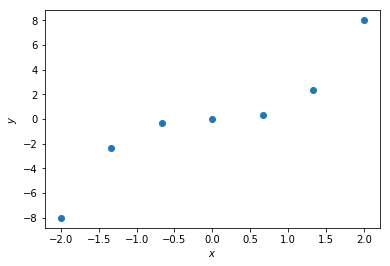

In [4]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

Предсказание  -2.53765262771e-16


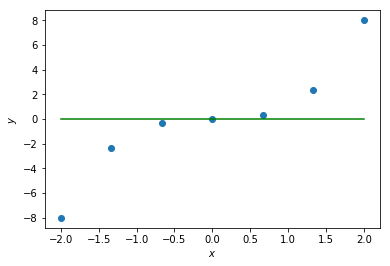

In [5]:
print('Предсказание ', np.mean(y))

# Построение графика
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

mean = np.mean(y)
y_pred = [mean for x in X]
plt.plot(X, y_pred, ls='-', c='g');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

-3.5555555555555554 2.666666666666666
          X         y    pred_y
0 -2.000000 -8.000000 -3.555556
1 -1.333333 -2.370370 -3.555556
2 -0.666667 -0.296296 -3.555556
3  0.000000  0.000000  2.666667
4  0.666667  0.296296  2.666667
5  1.333333  2.370370  2.666667
6  2.000000  8.000000  2.666667


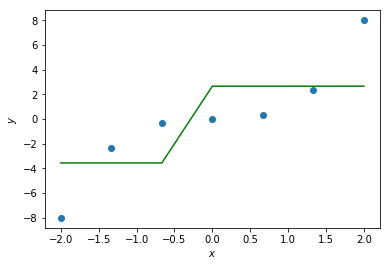

In [6]:
# Построение графика
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

df = pd.DataFrame({'X': X, 'y': y})
df['pred_y'] = 0
predicate = df['X'] < 0
mean_left = np.mean(df[predicate]['y'])
mean_right = np.mean(df[~predicate]['y'])
print(mean_left, mean_right)
df['pred_y'] = np.where(df['X']<0, mean_left, mean_right)
print(df)
plt.plot(df['X'], df['pred_y'], ls='-', c='g');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [7]:
def regression_var_criterion(X, y, t):
    df = pd.DataFrame({'X': X, 'y': y})
    df['pred_y'] = 0
    predicate = df['X'] < t
    xs = df.shape[0]
    xls = df[predicate].shape[0]
    xrs = df[~predicate].shape[0]
    var = np.var(df['y'])
    var_left = np.var(df[predicate]['y'])
    var_right = np.var(df[~predicate]['y'])
    print('For t={} D(X)={} D(Xl)={} D(Xr)={}'.format(t, var, var_left, var_right))
    result = var - (xls/xs)*var_left - (xrs/xs)*var_right
    print('Q(X,t) = {}'.format(result))
    return result

For t=-1.9 D(X)=19.916127767979617 D(Xl)=0.0 D(Xr)=10.791037951531779
Q(X,t) = 10.666666666666664
For t=-0.95 D(X)=19.916127767979617 D(Xl)=7.923182441700958 D(Xr)=9.657064471879286
Q(X,t) = 10.754458161865568
For t=0.0 D(X)=19.916127767979617 D(Xl)=10.593507087334247 D(Xr)=10.315500685871056
Q(X,t) = 9.481481481481481
For t=0.9499999999999997 D(X)=19.916127767979617 D(Xl)=9.657064471879284 D(Xr)=7.923182441700964
Q(X,t) = 10.754458161865566
For t=1.9 D(X)=19.916127767979617 D(Xl)=10.791037951531777 D(Xr)=0.0
Q(X,t) = 10.666666666666666


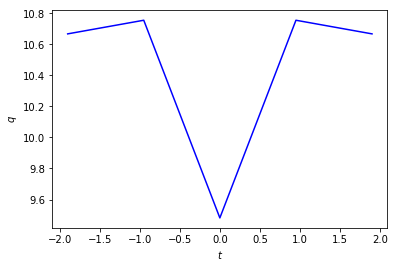

In [8]:
t = np.linspace(-1.9, 1.9, 5)
q = [regression_var_criterion(X, y, t_) for t_ in t]
plt.plot(t, q, ls='-', c='b')
plt.xlabel(r'$t$')
plt.ylabel(r'$q$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- **Да**
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

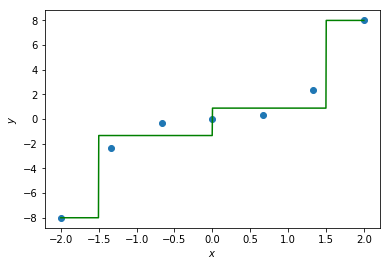

In [15]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

X_test = np.linspace(-2, 2, 1000)

import math
class MyDecisionTree:
    def __init__(self, criterias=[]):
        self.bounds = criterias
        self.bounds.append(-math.inf)
        self.bounds.append(math.inf)
        self.bounds.sort()
        self.leaves = [ {'y': [], 'value': 0} for _ in range(len(self.bounds)+1) ]

    def fit(self, X, y):
        for i, x in enumerate(X):
            index = 0
            # проверим попадает ли значение X в конкретный узел
            for j, point in enumerate(self.bounds, start=0):
                if x < point:
                    self.leaves[j]['y'].append(y[i])
                    break

            # посчитаем среднее значение функции в листьях дерева
            for leaf in self.leaves:
                if len(leaf['y'])>0:
                    leaf['value'] = np.mean(leaf['y']) 
    
    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, x in enumerate(X, start=0):
            for j, point in enumerate(self.bounds, start=0):
                if x < point:
                    y_pred[i] = self.leaves[j]['value']
                    break
        return y_pred 

mytree = MyDecisionTree([-1.5, 0, 1.5])
mytree.fit(X, y)
y_pred = mytree.predict(X_test)
plt.plot(X_test, y_pred, ls='-', c='g');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **7**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [40]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [41]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [57]:
df['age_in_years'] = df['age'] // 365.25
df_fixed = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df_fixed.drop(['cardio', 'age'], axis=1, inplace=True)
df_fixed.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_in_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50,1.0,0.0,0.0,1.0,0.0,0.0
1,1,156,85.0,140,90,0,0,1,55,0.0,0.0,1.0,1.0,0.0,0.0
2,1,165,64.0,130,70,0,0,0,51,0.0,0.0,1.0,1.0,0.0,0.0
3,2,169,82.0,150,100,0,0,1,48,1.0,0.0,0.0,1.0,0.0,0.0
4,1,156,56.0,100,60,0,0,0,47,1.0,0.0,0.0,1.0,0.0,0.0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(df_fixed, df['cardio'], test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [59]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file='../../img/hw3_tree.dot', feature_names=df_fixed.columns, \
                class_names=['Healthy', 'Ill'], filled=True, rounded=True, special_characters=True)
!dot ../../img/hw3_tree.dot -T png -o ../../img/hw3_tree.png

<img src='../../img/hw3_tree.png'>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [60]:
accuracy = tree.score(X_valid, y_valid)
print(accuracy)

0.721285714286


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [70]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid=tree_params, cv=5, \
                         return_train_score=True)
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
print(tree_grid.best_score_)


{'max_depth': 6}
0.732204081633


Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.058770,0.002372,0.715510,0.715510,2,{'max_depth': 2},9,0.711560,0.716498,0.713265,...,0.717551,0.715000,0.713571,0.715995,0.721604,0.713987,0.000409,0.000072,0.003625,0.000906
1,0.067765,0.002375,0.727714,0.727714,3,{'max_depth': 3},7,0.722069,0.729126,0.725612,...,0.732653,0.726480,0.723980,0.728648,0.734259,0.726078,0.001270,0.000036,0.004847,0.001212
2,0.079269,0.002855,0.730694,0.730694,4,{'max_depth': 4},3,0.725640,0.731957,0.728163,...,0.734286,0.729796,0.727857,0.731403,0.737524,0.728987,0.002879,0.000340,0.004462,0.001115
3,0.089533,0.002843,0.731102,0.733311,5,{'max_depth': 5},2,0.724620,0.734662,0.729490,...,0.735816,0.732832,0.728265,0.734286,0.737320,0.731384,0.003236,0.000428,0.004766,0.001160
4,0.112037,0.003730,0.732204,0.735408,6,{'max_depth': 6},1,0.725538,0.737238,0.729286,...,0.737245,0.734286,0.730408,0.736199,0.738545,0.734114,0.021477,0.000506,0.004935,0.001179


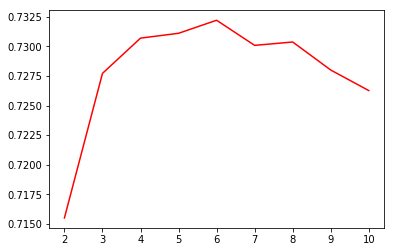

In [77]:
results = pd.DataFrame(tree_grid.cv_results_)

plt.plot(results['param_max_depth'], results['mean_test_score'], c='r');

results.head()

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [80]:
print(tree_grid.best_params_)
print(tree_grid.best_score_)

acc1 = 0.721285714286
acc2 = 0.732204081633
(acc2 - acc1) / acc1 * 100

{'max_depth': 6}
0.732204081633


1.513736807862347

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- **да, да**
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- **Верхнее артериальное давление от 140 до 160 (мм рт.ст.)**
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [95]:
df_tuned = df_fixed.copy()
df_tuned['ap_hi_120_140'] = np.where((df_tuned['ap_hi']>=120) & (df_tuned['ap_hi']<140), 1, 0)
df_tuned['ap_hi_140_160'] = np.where((df_tuned['ap_hi']>=140) & (df_tuned['ap_hi']<160), 1, 0)
df_tuned['ap_hi_160_180'] = np.where((df_tuned['ap_hi']>=160) & (df_tuned['ap_hi']<180), 1, 0)
df_tuned['age_45_50'] = np.where((df_tuned['age_in_years']>=45) & (df_tuned['age_in_years']<50), 1, 0)
df_tuned['age_50_55'] = np.where((df_tuned['age_in_years']>=50) & (df_tuned['age_in_years']<55), 1, 0)
df_tuned['age_55_60'] = np.where((df_tuned['age_in_years']>=55) & (df_tuned['age_in_years']<60), 1, 0)
df_tuned['age_60_65'] = np.where((df_tuned['age_in_years']>=60) & (df_tuned['age_in_years']<65), 1, 0)
df_tuned['male'] = np.where(df_tuned['gender']==1, 0, 1)

features = ['ap_hi_120_140', 'ap_hi_140_160', 'ap_hi_160_180', 'age_45_50', 'age_50_55', 'age_55_60', \
            'age_60_65', 'smoke', 'male', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3']
X_train = df_tuned[features]


tt = DecisionTreeClassifier(max_depth=3, random_state=17)
tt.fit(X_train, df['cardio'])
export_graphviz(tt, out_file='../../img/hw3_tree_final.dot', feature_names=features, \
                class_names=['Healthy', 'Ill'], filled=True, rounded=True, special_characters=True)
!dot ../../img/hw3_tree_final.dot -T png -o ../../img/hw3_tree_final.png

<img src='../../img/hw3_tree_final.png'>